**Neural networks for road segmentation**
========================

Your next task is to train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

In [1]:
import os
import cv2
import numpy as np

import torch
import torchvision
import torch.nn as nn
import albumentations as A
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

from albumentations.pytorch import ToTensorV2
from torchsummary import summary
from torch.utils.data import Dataset
from tqdm.notebook import tqdm as tqdm
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter

from torchmetrics.functional import jaccard_index

%matplotlib inline

In [2]:
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):            
        images_paths.append(os.path.join(path, filename))
    
    return np.stack(images_paths)

class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, transform):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        im_name = self.images[idx]
        mask_name = self.masks[idx]
        
        image = cv2.imread(im_name)[:,:,::-1] / 255.0  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)
            
        augmented = self.transform(image=image,
                                   mask=mask)
        sample = {}
        sample['image'] = augmented['image']
        sample['mask'] = augmented['mask']

        return sample

In [3]:
X_train = get_paths("./data/train/images")
y_train = get_paths("./data/train/gt")

X_test = get_paths("./data/test/images")
y_test = get_paths("./data/test/gt")

train_transform = A.Compose([
    A.HorizontalFlip(),
    A.RandomRotate90(),
    A.RandomGamma(p=0.5),
#     A.ColorJitter(p=0.5),
    A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
    ], p=0.15),
    A.PadIfNeeded(min_height=512, min_width=512),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.PadIfNeeded(min_height=512, min_width=512),
    ToTensorV2(),
])

In [4]:
train_dataset = RoadDataset(X_train, y_train, train_transform)
test_dataset = RoadDataset(X_test, y_test, test_transform)

torch.Size([3, 512, 512]) torch.Size([512, 512])


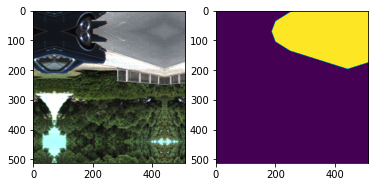

In [5]:
sample = train_dataset[4]
image = sample['image']
mask = sample['mask']

print(image.shape, mask.shape)
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)

Workflow:
---
* Choose correct loss function, write training loop and code for testing. Feel free to use previous HW for inspiration. 
* Train any segmentation neural network from scratch (for example U-Net) and achieve >= 0.75 IoU on test set (40% points). See function to calculate the metric below.
* Use any pretrained model for image classification, convert it for segmentation by adding decoder (don't forget skip-connections) or usign dilated convolutions and achieve >= 0.87 IoU  on test set (60% points).

You're not allowed to do only one thing: train your network on test set.

----
Your final solution will consist of an ipython notebook with code (for final networks training + any experiments with data) and test metric calculation.

Feel free to ask in Telegram chat if something is not clear :3


In [6]:
print(f"Dataset length {len(train_dataset)}")

Dataset length 648


Dataset is small so actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

Most likely you'll have to pad your images to 512x512 (it divides by 2^5=32, like U-Net wants). Use PadIfNeeded from Albumentations and central crop (see below) after prediction to calculate loss/metrics (you don't want to pay attention on padded values).

----
There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. You also can try to use softIoU or DICE loss.

Good luck!

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
def calc_iou(pred, target):
    pred = pred.view(-1).contiguous()
    target = target.view(-1).contiguous()

    intersection = (pred * target).sum()                            
    iou = intersection / (pred.sum() + target.sum() - intersection) 
    
    return iou

def calc_dice(pred, target, alpha = 0.75):
    pred = pred.view(-1).contiguous()
    target = target.view(-1).contiguous()

    intersection = (pred * target).sum()                            
    dice = (2 * intersection + alpha) / (pred.sum() + target.sum() + alpha) 
    
    return dice

def calc_focal(pred, target, alpha=0.8, gamma=2, smooth=1):  
    pred = pred.view(-1)
    target = target.view(-1)

    BCE = F.binary_cross_entropy(pred, target, reduction='mean')
    BCE_EXP = torch.exp(-BCE)
    focal_loss = alpha * (1 - BCE_EXP) ** gamma * BCE

    return focal_loss

def calc_loss(pred, target):
#     weights = torch.eye(target.shape[0]) * 1 + 1
    
#     bce_loss = F.binary_cross_entropy(pred, target.unsqueeze(1), 
#                                                   weight=weights.to(device)
#                                                  )
    dice_loss = 1 - calc_dice(pred, target)
    focal_loss = calc_focal(pred, target)
    
    loss = focal_loss + dice_loss
    
    
    
    return loss

In [9]:
BATCH_SIZE = 10
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE,
                                           num_workers=12)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, 
                                          num_workers=12)

### Model U-Net

In [10]:
class ConvLayer(nn.Module):
    
    def __init__(self, input_channels, output_channels, mid_channels=None, padding='same'):
        super().__init__()
        
        if mid_channels is None:
            mid_channels = output_channels
            
        self.conv1 = nn.Conv2d(in_channels=input_channels, 
                               out_channels=mid_channels,
                               kernel_size=(3, 3),
                               padding=padding,
                               dilation=2,
                               bias=False)
        self.conv2 = nn.Conv2d(in_channels=mid_channels, 
                               out_channels=output_channels,
                               kernel_size=(3, 3),
                               padding=padding,
                               dilation=2,
                               bias=False)
        
        self.dropout = nn.Dropout(0.15)
        self.use_dropout = True
        
        self.batchnorm1 = nn.BatchNorm2d(num_features=output_channels)
        self.batchnorm2 = nn.BatchNorm2d(num_features=output_channels)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        
    
    def forward(self, input):
        x = self.conv1(input)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        
        if self.use_dropout:
            x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        
        
        return x

In [11]:
class DownScaller(nn.Module):
    
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv_layer = ConvLayer(input_channels, output_channels)
    
    def forward(self, input):
        x = self.maxpool(input)
        x = self.conv_layer(x)

        return x

In [12]:
class UpScaler(nn.Module):
    
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv_transposed = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=2, stride=2)
        self.conv_layer = ConvLayer(input_channels, output_channels, input_channels // 2)
           
    def forward(self, x1, x2):
        x1 = self.conv_transposed(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv_layer(x)
        
        return x
        

In [13]:
class UNet(nn.Module):
    
    def __init__(self):
        super().__init__()
                
        self.input_channel = 3
        self.output_channel = 16
        self.n_classes = 1
        
        self.conv1 = ConvLayer(self.input_channel, self.output_channel)
        
        self.down1 = DownScaller(self.output_channel * 1, self.output_channel * 2)
        self.down2 = DownScaller(self.output_channel * 2, self.output_channel * 4)
        self.down3 = DownScaller(self.output_channel * 4, self.output_channel * 8)
        self.down4 = DownScaller(self.output_channel * 8, self.output_channel * 16)
        self.down5 = DownScaller(self.output_channel * 16, self.output_channel * 32)
        
        self.up1 = UpScaler(self.output_channel * 32, self.output_channel * 16)
        self.up2 = UpScaler(self.output_channel * 16, self.output_channel * 8)
        self.up3 = UpScaler(self.output_channel * 8, self.output_channel * 4)
        self.up4 = UpScaler(self.output_channel * 4, self.output_channel * 2)
        self.up5 = UpScaler(self.output_channel * 2, self.output_channel * 1)

        self.conv3 = nn.Conv2d(self.output_channel * 1, self.n_classes, kernel_size=(3, 3), padding='same')
        self.sigmoid = nn.Sigmoid()
        
    
    def forward(self, input):
               
        x_1 = self.conv1(input)
        x_2 = self.down1(x_1)
        x_3 = self.down2(x_2)
        x_4 = self.down3(x_3)
        x_5 = self.down4(x_4)
        x_6 = self.down5(x_5)

        x_7 = self.up1(x_6, x_5)
        x_8 = self.up2(x_7, x_4)      
        x_9 = self.up3(x_8, x_3)
        x_10 = self.up4(x_9, x_2)
        x_11 = self.up5(x_10, x_1)
        
        output = self.conv3(x_11)
        output = self.sigmoid(output)
        
        return output

In [11]:
# CHECK
unet = UNet()
a = torch.rand([4, 3, 512, 512])
out = unet(a)

print(out.shape)

torch.Size([4, 1, 512, 512])


### Train U-Net

In [12]:
EPOCHS = 5
learning_rate = 0.001

In [13]:
# model = UNet().to(device)
# summary(model, input_size=train_dataset[0]['image'].shape)

In [14]:
def train_model(model, data_loader, optimizer, epoch):
    loss_history = []
    iou_history = []
    acc_history = []
    
    for i, batch in enumerate(tqdm(data_loader, desc='TRAIN')):
        x_batch, y_batch = batch['image'].to(device).float(), batch['mask'].to(device).float()
        
        output = model(x_batch)
        loss = calc_loss(output, y_batch)
        loss.backward()
           
        optimizer.step()
        optimizer.zero_grad()
        
        loss_history.append(loss.item())
        iou_history.append(jaccard_index(output, y_batch.int(), num_classes=2).cpu().detach().numpy())
        
          
        writer.add_scalars('Train', 
                   {'Loss': loss_history[-1], 'IoU': iou_history[-1]}, 
                   i + epoch * len(train_dataset) // BATCH_SIZE)
        
    print(f'Loss: {np.mean(loss_history):.3f} ± {np.std(loss_history):.3f}\
            IoU: {np.mean(iou_history):.3f}  ± {np.std(iou_history):.3f}' )
    
    return model

In [15]:
@torch.no_grad()
def eval_model(model, data_loader, scheduler, epoch):
    loss_history = []
    iou_history = []
    
    for i, batch in enumerate(tqdm(data_loader, desc='VALID')):
        x_batch, y_batch = batch['image'].to(device).float(), batch['mask'].to(device).float()
        
        output = model(x_batch)
        loss = calc_loss(output, y_batch)
        
        loss_history.append(loss.item() )
        iou_history.append(jaccard_index(output, y_batch.int(), num_classes=2).cpu().detach().numpy())
        
        writer.add_scalars('Valid', 
                           {'Loss': loss_history[-1], 'IoU': iou_history[-1]}, 
                           i + epoch * len(test_dataset) // BATCH_SIZE)
    
    print(f'Loss: {np.mean(loss_history):.3f} ± {np.std(loss_history):.3f}\
            IoU: {np.mean(iou_history):.3f}  ± {np.std(iou_history):.3f}')

In [19]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

writer = SummaryWriter(comment='_test2')

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=.75, verbose=True)

for epoch in tqdm(range(EPOCHS), desc='EPOCH'):
    print('-' * 50, f'Epoch {epoch + 1} / {EPOCHS}', '-' * 50)
    
    model.train(True) 
    model = train_model(model, train_loader, optimizer, epoch)
    
    model.train(False) 
    eval_model(model, test_loader, scheduler, epoch)
    
    scheduler.step()
    torch.cuda.empty_cache()

2022-07-21 23:18:35.573443: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/manoshin/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-21 23:18:35.573479: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Adjusting learning rate of group 0 to 1.0000e-03.


EPOCH:   0%|          | 0/5 [00:00<?, ?it/s]

-------------------------------------------------- Epoch 1 / 5 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.406 ± 0.171            IoU: 0.711  ± 0.118


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.448 ± 0.331            IoU: 0.677  ± 0.185
Adjusting learning rate of group 0 to 1.0000e-03.
-------------------------------------------------- Epoch 2 / 5 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.252 ± 0.104            IoU: 0.777  ± 0.075


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.464 ± 0.425            IoU: 0.682  ± 0.186
Adjusting learning rate of group 0 to 1.0000e-03.
-------------------------------------------------- Epoch 3 / 5 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.232 ± 0.089            IoU: 0.788  ± 0.068


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.452 ± 0.390            IoU: 0.685  ± 0.184
Adjusting learning rate of group 0 to 1.0000e-03.
-------------------------------------------------- Epoch 4 / 5 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.220 ± 0.084            IoU: 0.798  ± 0.063


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.548 ± 0.486            IoU: 0.647  ± 0.194
Adjusting learning rate of group 0 to 1.0000e-03.
-------------------------------------------------- Epoch 5 / 5 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.214 ± 0.092            IoU: 0.801  ± 0.067


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.303 ± 0.240            IoU: 0.761  ± 0.145
Adjusting learning rate of group 0 to 1.0000e-03.


In [54]:
@torch.no_grad()
def score_dataset(model, dataset):
    
    iou = 0 
    for idx in tqdm(range(len(dataset))):
        sample = dataset[idx]
        x_batch, y_batch = sample['image'].to(device).float(), sample['mask'].to(device).int()
        
        output = model(x_batch[None, ...])
        iou += jaccard_index(output, y_batch, num_classes=2).cpu().detach().numpy()
        
    print(f"IoU: {iou / len(dataset):.3f}")

In [58]:
def visualize(model):
    random_img_count = 5
    random_test_idx = np.random.choice(list(range(len(test_dataset))), size=random_img_count, replace=False)

    for idx in random_test_idx:
        sample = test_dataset[idx]
        image, mask = sample['image'].to(device).float(), sample['mask'].to(device)
        pred_mask = model(image[None, :, :, :])

        plt.subplot(1, 3, 1)
        plt.title('Image')
        plt.imshow(image.cpu().permute(1, 2, 0))
        plt.subplot(1, 3, 2)
        plt.title('Prediction mask')
        plt.imshow(pred_mask.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
        plt.subplot(1, 3, 3)
        plt.title('GT')
        plt.imshow(mask.cpu().detach().numpy())
        plt.show()

In [56]:
score_dataset(model, train_dataset)

  0%|          | 0/648 [00:00<?, ?it/s]

IoU: 0.764


In [66]:
score_dataset(model, test_dataset)

  0%|          | 0/219 [00:00<?, ?it/s]

IoU: 0.757


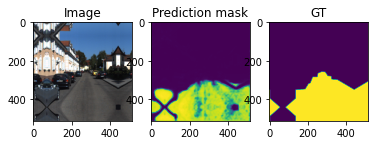

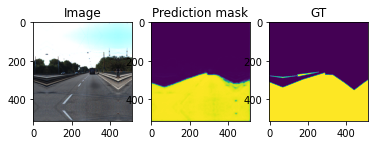

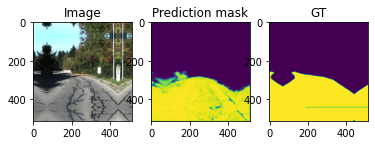

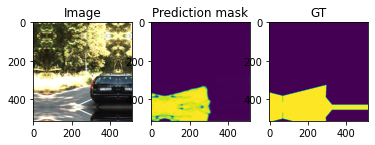

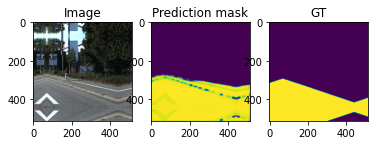

In [61]:
visualize(model)

In [65]:
# torch.save(model, './models/custom_unet.pth')

model = torch.load('./models/custom_unet.pth')

## Unet with pretrained backbone

In [28]:
summary(backbone, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
       BasicBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

In [16]:
class UNet_ResNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.backbone = torchvision.models.resnet18(pretrained=True).to(device)
        
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        self.up1 = UpScaler(512, 256)
        self.up2 = UpScaler(256, 128)
        self.up3 = UpScaler(128, 64)
        self.up4 = UpScaler(64, 32)
        self.up5 = UpScaler(32, 16)
        
        self.conv_x_1 = nn.Conv2d(64, 32, (3, 3), padding='same')
        self.bn_x_1 = nn.BatchNorm2d(32)
        
        self.conv_out = nn.Conv2d(16, 1, kernel_size=(3, 3), padding='same')
        self.sigmoid = nn.Sigmoid()
        
        self.conv1 = nn.Conv2d(3, 64, (3, 3), padding='same')
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 16, (3, 3), padding='same')
        self.bn2 = nn.BatchNorm2d(16)
        
    def forward(self, input):
        
        # input
        x_input = self.conv1(input)
        x_input = self.bn1(x_input)
        x_input = F.relu(x_input)
        x_input = self.conv2(x_input)
        x_input = self.bn2(x_input)
        x_input = F.relu(x_input)
        
        # Encoder
        x_1 = self.backbone.conv1(input)
        x_1 = self.backbone.bn1(x_1)
        x_1 = self.backbone.relu(x_1)
        x_2 = self.backbone.maxpool(x_1)
        x_2 = self.backbone.layer1(x_2)
        x_3 = self.backbone.layer2(x_2)
        x_4 = self.backbone.layer3(x_3)
        x_5 = self.backbone.layer4(x_4)
        
        # Decoder
        x_6 = self.up1(x_5, x_4)
        x_7 = self.up2(x_6, x_3)
        x_8 = self.up3(x_7, x_2)
        
        x_1_res = self.conv_x_1(x_1)
        x_1_res = self.bn_x_1(x_1_res)
        x_1_res = F.relu(x_1_res)
        x_9 = self.up4(x_8, x_1_res) 
        
        x_10 = self.up5(x_9, x_input)
        
        output = self.conv_out(x_10)
        output = self.sigmoid(output)
        
        return output

In [17]:
model = UNet_ResNet().to(device)
summary(model, input_size=train_dataset[0]['image'].shape)

torch.Size([2, 64, 256, 256])
torch.Size([2, 64, 128, 128])
torch.Size([2, 128, 64, 64])
torch.Size([2, 256, 32, 32])
torch.Size([2, 512, 16, 16])
torch.Size([2, 256, 32, 32])
torch.Size([2, 128, 64, 64])
torch.Size([2, 64, 128, 128])
torch.Size([2, 32, 256, 256])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
       BatchNorm2d-2         [-1, 64, 512, 512]             128
            Conv2d-3         [-1, 16, 512, 512]           9,232
       BatchNorm2d-4         [-1, 16, 512, 512]              32
            Conv2d-5         [-1, 64, 256, 256]           9,408
       BatchNorm2d-6         [-1, 64, 256, 256]             128
              ReLU-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]          36,864
      BatchNorm2d-10         [

In [17]:
learning_rate = 0.001
EPOCHS = 11

In [18]:
model = UNet_ResNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

writer = SummaryWriter(comment='_test2')

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=.75, verbose=True)

for epoch in tqdm(range(EPOCHS), desc='EPOCH'):
    print('-' * 50, f'Epoch {epoch + 1} / {EPOCHS}', '-' * 50)
    
    model.train(True) 
    model = train_model(model, train_loader, optimizer, epoch)
    
    model.train(False) 
    eval_model(model, test_loader, scheduler, epoch)
    
#     scheduler.step()
    torch.cuda.empty_cache()

2022-07-26 00:11:24.670589: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/manoshin/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-26 00:11:24.670629: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Adjusting learning rate of group 0 to 1.0000e-03.


EPOCH:   0%|          | 0/11 [00:00<?, ?it/s]

-------------------------------------------------- Epoch 1 / 11 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.338 ± 0.187            IoU: 0.781  ± 0.111


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.205 ± 0.158            IoU: 0.837  ± 0.101
-------------------------------------------------- Epoch 2 / 11 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.160 ± 0.080            IoU: 0.850  ± 0.061


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.158 ± 0.118            IoU: 0.860  ± 0.084
-------------------------------------------------- Epoch 3 / 11 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.147 ± 0.073            IoU: 0.856  ± 0.056


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.196 ± 0.112            IoU: 0.826  ± 0.073
-------------------------------------------------- Epoch 4 / 11 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.133 ± 0.060            IoU: 0.865  ± 0.050


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.165 ± 0.128            IoU: 0.854  ± 0.084
-------------------------------------------------- Epoch 5 / 11 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.127 ± 0.048            IoU: 0.869  ± 0.040


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.172 ± 0.123            IoU: 0.840  ± 0.087
-------------------------------------------------- Epoch 6 / 11 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.124 ± 0.053            IoU: 0.872  ± 0.043


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.167 ± 0.131            IoU: 0.847  ± 0.089
-------------------------------------------------- Epoch 7 / 11 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.113 ± 0.050            IoU: 0.883  ± 0.042


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.210 ± 0.122            IoU: 0.816  ± 0.080
-------------------------------------------------- Epoch 8 / 11 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.112 ± 0.047            IoU: 0.883  ± 0.037


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.137 ± 0.107            IoU: 0.870  ± 0.075
-------------------------------------------------- Epoch 9 / 11 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.106 ± 0.042            IoU: 0.887  ± 0.037


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.227 ± 0.120            IoU: 0.812  ± 0.070
-------------------------------------------------- Epoch 10 / 11 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.097 ± 0.039            IoU: 0.895  ± 0.036


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.130 ± 0.102            IoU: 0.876  ± 0.072
-------------------------------------------------- Epoch 11 / 11 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.102 ± 0.038            IoU: 0.891  ± 0.034


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.144 ± 0.114            IoU: 0.865  ± 0.079
